In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

## Preprocessing


In [2]:
def process_image(img_path, output_path='./Processed.png', ksize=3, t1=21, t2=5):
    """
        Process the provided image using opencv2 to
        remove shadows & put more emphasis on the text.
    Params:
        - img_path:       str         : Path of the image to process on disk
        - output_path:    str         : Path of the output image on disk
                                        Defaults to: '/tmp/Processed.png'
    Returns:
        None
    """
    image = cv2.imread(img_path)
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (ksize, ksize), 0)

    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY, t1, t2)

    # Apply morphological operations
    kernel = np.ones((2, 2), np.uint8)
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    cv2.imwrite(output_path, morph)

## Manual segmentation

In [3]:
def get_minimas(data, t1, t2):
    """
        Finds the local minimas in the given data based on the provided thresholds.
    Args:
        - data (list): List of y-values to find the local minimas in.
        - t1 (float): How much of an inclintation (in pixels) should be present to consider the min_so_far as the local minima.
        - t2 (float): Min depth of the min_point relative to a potential maxima to consider it as a valid local minima.
    Returns:
        - tuple:  A tuple containing two lists. The first list contains the indices (row_num or col_num etc) of the local minimas,
                and the second list contains the values (amplitude) of the local minimas across the other axis.
    """
    
    minima = []
    minima_idx = []

    min_so_far, min_so_far_idx, max_so_far = 10 ** 10, -1, 0

    for idx, point in enumerate(data):
        # New minima ?
        if point < min_so_far:
            min_so_far = point
            min_so_far_idx = idx

        # Finding a potential maxima invalidates our old minima
        if point > max_so_far:
            max_so_far = point
            min_so_far = point
            min_so_far_idx = idx
        
        if point - min_so_far >= t1 and max_so_far - min_so_far >= t2:
            minima.append(min_so_far)
            minima_idx.append(min_so_far_idx)

            min_so_far = max_so_far = point
            min_so_far_idx = idx

    return minima_idx, minima

def get_maximas(data, t1, t2):
    """
        Finds the local maximas in the given data based on the provided thresholds.
    Args:
        - data (list): List of y-values to find the local maximas in.
        - t1 (float): How much of an inclintation (in pixels) should be present to consider the max_so_far as the local maxima.
        - t2 (float): Min height of the max_point relative to a potential minima to consider it as a valid local maxima.
    Returns:
        - tuple:  A tuple containing two lists. The first list contains the indices in the provided data (row_num or col_num etc)
                of the local maximas, and the second list contains the values (amplitude) of the local maximas across the other axis.
    """
    maxima = []
    maxima_idx = []
    increasing_before = True
    decreasing_after = False

    max_so_far, max_so_far_idx, min_so_far = 0, -1, 10 ** 10

    for idx, point in enumerate(data):
        # New maxima ?
        if point > max_so_far:
            max_so_far = point
            max_so_far_idx = idx

        # Finding a potential minima invalidates our old minima
        if point < min_so_far:
            min_so_far = point
            max_so_far = point
            max_so_far_idx = idx
        
        if max_so_far - point >= t1 and max_so_far - min_so_far >= t2:
            maxima.append(max_so_far)
            maxima_idx.append(max_so_far_idx)

            max_so_far = min_so_far = point
            max_so_far_idx = idx

    return maxima_idx, maxima

In [4]:
def moving_average(y, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    y_smooth = np.convolve(y, window, 'same')
    return y_smooth

In [5]:
def merge_minima_maxima(minima_idx, minima, maxima_idx, maxima):
    """
        Merge the arrays of minima and maxima into a single array alteratively (minima, maxima, minima or vice versa).
    Args:
        - minima_idx (list): List of indices corresponding to the minima values.
        - minima (list): List of minima values.
        - maxima_idx (list): List of indices corresponding to the maxima values.
        - maxima (list): List of maxima values.
    Returns:
        - tuple:  A tuple containing the merged indices array, merged values array, and a boolean indicating if the minima
                are even-indexed or odd-indexed.
    """
    
    n_min, n_max = len(minima), len(maxima)
    n_merged = n_min + n_max 
    
    merged_arr = np.zeros(n_merged)
    merged_idx_arr = np.zeros(n_merged)
    
    minimas_even_indexed = (n_min != 0) and (n_max == 0 or minima_idx[0] < maxima_idx[0])
    idx1 = idx2 = 0
    for i in range(n_merged):
        if idx1 < n_min and ((idx2 >= n_max) or not (minimas_even_indexed ^ ((i & 1) == 0))):
            merged_arr[i] = minima[idx1]
            merged_idx_arr[i] = minima_idx[idx1]
            idx1 += 1
        else:
            merged_arr[i] = maxima[idx2]
            merged_idx_arr[i] = maxima_idx[idx2]
    
    merged_idx_arr = merged_idx_arr.astype(int)
    return merged_idx_arr, merged_arr, minimas_even_indexed 

In [6]:
def get_line_boundaries(movingavg_horizontal, minima_maxima_data, minima_maxima_idx, minimas_even_indexed, line_padding_y, min_threshold, min_line_width):
    """
        Calculates the boundaries of lines in an image based on the provided parameters.
    Parameters:
        - movingavg_horizontal (list): The y-values of data after being processed by the moving average function.
        - minima_maxima_data (list): The merged minima/maxima data returned by merge_minima_maxima().
        - minima_maxima_idx (list): The indices of teh minima/maxima data in the movingavg_horizontal List.
        - minimas_even_indexed (bool): A boolean value indicating whether the minimas are located at even indices or odd indices.
        - line_padding_y (int): Padding on either ends of the line boundaries.
        - min_threshold (int): The minimum value for a point in movingavg_horizontal to be considered a part of a line..
        - min_line_width (int): The minimum width to quantify a potential line segment as a proper line.
    Returns:
        - line_boundaries (list): A list of tuples representing the lower and upper boundaries of each line.
    """
    
    n_merged = len(minima_maxima_data)
    rows = len(movingavg_horizontal)
    # line_boundaries = np.zeros(rows)
    line_boundaries = []
    # Based on picture dimensions
    offset = 0 #0.8 # TODO: Incorporate in adaptive thresholding

    for i in range(1 if minimas_even_indexed else 0, n_merged, 2):
        minima_idx_before = (minima_maxima_idx[i - 1] if i > 0 else 0) + line_padding_y
        minima_idx_after  = (minima_maxima_idx[i + 1] if i < n_merged - 1 else rows - 1) - line_padding_y
        # Make sure the values are within the bounds provided
        # max(value, 0) acts the lower bound, whoch min(max_result, rows_count - 1)
        # makes sure the value doesn't exceed the available capacity
        minima_idx_before = min(max(minima_idx_before, 0), rows - 1)
        minima_idx_after  = min(max(minima_idx_after,  0), rows - 1)
        minima_maxima_idx
        maxima_idx = min(max(minima_maxima_idx[i], 0), rows - 1)
    
        # TODO: Create an adaptive threshold based on minima values before / after, maxima val & global maxima
        # Currently it only uses global maxima
        #threshold = min_val + (vals_range) * (1 - (merged_arr[i] / max_val) - offset)
        # threshold = min(max(threshold, min_threshold), max_threshold)
        # threshold = 0

        # lower_bound = upper_bound = maxima_idx
        
    
        lower_bound = max(minima_idx_before, 0)
        upper_bound = min(minima_idx_after, rows - 1)
        
        while lower_bound < minima_idx_after and movingavg_horizontal[lower_bound] < min_threshold:
            lower_bound += 1
        
        while upper_bound > minima_idx_before and movingavg_horizontal[upper_bound] < min_threshold:
            upper_bound -= 1

        if upper_bound - lower_bound >= min_line_width:
            # for idx in range(lower_bound, upper_bound):
                # line_boundaries[idx] = 1
            line_boundaries.append((lower_bound, upper_bound))

    return line_boundaries

In [7]:
def output_image(img_name, show_processed=True, output_processed=True, moving_avg_window=10, highlight_alpha=0.4, line_padding_y=15, min_line_width=0, min_threshold=0):
    """
        Process the input image and extract line boundaries.
    Args:
        - img_name (str): The name of the input image file.
        - show_processed (bool, optional): Whether to display the processed image. Defaults to True.
        - output_processed (bool, optional): Whether to save the processed lines as separate images. Defaults to True.
        - moving_avg_window (int, optional): The window size for moving average smoothing. Defaults to 10.
        - highlight_alpha (float, optional): The transparency of the highlighted lines. Defaults to 0.4.
        - line_padding_y (int, optional): The padding applied to the line boundaries in the y-axis. Defaults to 15.
        - min_line_width (int, optional): The minimum width of a line. Defaults to 0.
        - min_threshold (int): The minimum value for a point in movingavg_horizontal to be considered a part of a line..
    Returns:
        - list: A list of tuples representing the lower and upper boundaries of each line.
    """
    process_image(img_name, './tmp.png')
    img = cv2.imread('./tmp.png', cv2.IMREAD_GRAYSCALE)

    if np.max(img) == 1:
        bin_img = img
    else:
        _, bin_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

    rows_count, column_count = bin_img.shape

    horizontal_vals = np.zeros(rows_count)
    for i in range(rows_count):
        horizontal_vals[i] = sum(bin_img[i] == 0)

    movingavg_horizontal = moving_average(horizontal_vals, window_size = moving_avg_window)
    minimas_idx, minimas = get_minimas(movingavg_horizontal, 50, 50)
    maximas_idx, maximas = get_maximas(movingavg_horizontal, 50, 50)
    
    # min_val, max_val = min(movingavg_horizontal), max(movingavg_horizontal)
    # vals_range = max_val - min_val

    minima_maxima_idx, minima_maxima_vals, minimas_even_indexed = merge_minima_maxima(minimas_idx, minimas, maximas_idx, maximas)

    line_boundaries = get_line_boundaries(movingavg_horizontal, minima_maxima_vals, minima_maxima_idx, minimas_even_indexed, line_padding_y=line_padding_y,
                                          min_line_width=min_line_width, min_threshold=min_threshold)
    if output_processed:
        if not os.path.isdir('lines/'):
            os.makedirs('lines/')

        img_basename = os.path.basename(img_name)
        for idx, bounds in enumerate(line_boundaries):
            lower_bound, upper_bound = bounds
            cv2.imwrite(f'lines/{idx}_{img_basename}', img[lower_bound:upper_bound + 1])

    if show_processed:
        plt.figure(1, figsize=(20, 40))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        for idx, bounds in enumerate(line_boundaries):
            lower_bound, upper_bound = bounds
            plt.axhspan(lower_bound, upper_bound, xmax=column_count, color='blue', alpha=highlight_alpha)

        indices = range(rows_count)
        plt.plot(movingavg_horizontal, indices)
        plt.scatter(minimas, minimas_idx, color='red')
        plt.scatter(maximas, maximas_idx, color='orange')

    return line_boundaries


## Test line segementation

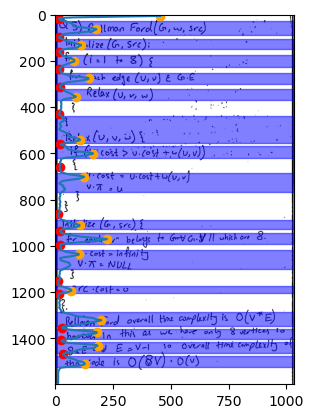

In [8]:
_ = output_image('samples/sample1.jpeg', moving_avg_window=10, highlight_alpha=0.5, line_padding_y=5, min_line_width=10, min_threshold=30)


## Word Seg testing

In [9]:
def get_word_boundaries(moving_avg_arr, threshold):
    """
        Returns a list of tuples representing the boundaries of words in a moving average array.
    Parameters:
        - moving_avg_arr (list): A list of floating-point numbers representing the moving average array.
        - threshold (float): The threshold to consider a point to be inside a word or outside it.
    Returns:
        - word_boundaries (list): A list of tuples representing the boundaries of words. Each tuple contains the starting index and ending index of a word.
    """
    word_boundaries = []
    columns_count = len(moving_avg_arr)

    if columns_count == 0:
        return []
    
    last_val, last_val_idx = moving_avg_arr[0], 0
    
    idx = 0
    while idx < columns_count:
        # If last point and current point are both above or below the threshold, skip
        # In other words, if we currently completely inside the word boundary or
        # completely outside it
        if (moving_avg_arr[idx] >= threshold and last_val >= threshold) or (moving_avg_arr[idx] < threshold and last_val < threshold):
            idx += 1
            continue

        # If the current point is below the threshold, we are exiting a word boundary
        # Otherwise, we are entering a word boundary
        if moving_avg_arr[idx] < threshold:
            word_boundaries.append((last_val_idx, idx))
        else:
            last_val_idx = idx
        last_val = moving_avg_arr[idx]

    if moving_avg_arr[-1] > threshold:
        word_boundaries.append((last_val_idx, columns_count - 1))

    return word_boundaries

In [10]:
def output_image_T(img_name, show_original=False, show_processed=True, output_processed=False, highlight_alpha=0.4, word_thresh=0):
    """
        Process an image of a line and extract word/char boundaries. Works similar to output_image but across the other axis.
    Parameters:
        - img_name (str): The path to the input image file.
        - show_original (bool): Whether to display the original image. Default is False.
        - show_processed (bool): Whether to display the processed image with word boundaries highlighted. Default is True.
        - output_processed (bool, optional): Whether to save the processed words/chars as separate images. Defaults to False.
        - highlight_alpha (float): The transparency level of the highlighted word boundaries. Default is 0.4.
        - word_thresh (int): The threshold to consider a point to be inside a word or outside it.
    Returns:
        - word_boundaries (list): A list of tuples representing the lower and upper boundaries of each word in the image.
    """
    process_image(img_name, './tmp.png')
    img = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)

    # Binarize the image if it hasn't been already
    if np.max(img) == 1:
        bin_img = img
    else:
        _, bin_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    
    if show_original:
        plt.imshow(cv2.cvtColor(bin_img, cv2.COLOR_BGR2RGB))

    rows_count, column_count = bin_img.shape

    # Calculate the number of black pixels in each column
    vertical_vals = np.zeros(column_count)
    for i in range(column_count):
        vertical_vals[i] = sum(bin_img[:, i] == 0)
    word_boundaries = get_word_boundaries(vertical_vals, word_thresh)

    if show_processed:
        plt.figure(2, figsize=(50, 100))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        for idx, bounds in enumerate(word_boundaries):
            lower_bound, upper_bound = bounds
            plt.axvspan(lower_bound, upper_bound, ymax=rows_count, color='blue', alpha=highlight_alpha)

        indices = range(column_count)
        plt.plot(indices, vertical_vals)
    
    if output_processed:
        if not os.path.isdir('words'):
            os.makedirs('words')

        for idx, bounds in enumerate(word_boundaries):
            lower_bound, upper_bound = bounds
            cv2.imwrite(f'words/{idx}.png', img[:, lower_bound:upper_bound + 1])

    return word_boundaries

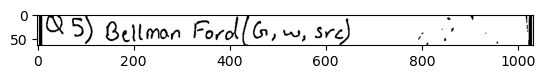

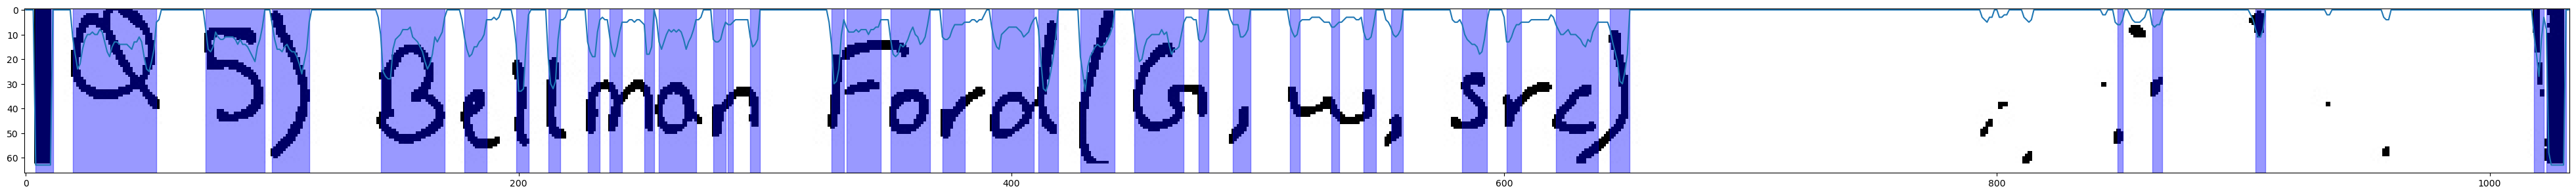

In [11]:
bounds = output_image_T('lines/0_sample1.jpeg', show_original=True, show_processed=True, output_processed=False, word_thresh = 6)

In [12]:
def get_bboxes(img_name, img):
    bboxes = []

    vboxes = output_image(img_name, show_processed=True, min_line_width=10, min_threshold=20)
    for ly, uy in vboxes:
        cv2.imwrite(f'/tmp/curr.png', img[ly:uy + 1])
        hboxes = output_image_T(f'/tmp/curr.png', show_processed=False, word_thresh=5)
        # limg = img[ly:uy + 1].copy()
        # for lx, ux in hboxes:
        #     limg = cv2.rectangle(limg, (lx, 0), (ux, limg.shape[0]), (0, 255, 0), 2)
        # cv2.imshow(f'/tmp/img/{ly}_{uy}.png', limg)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

        for lx, ux in hboxes:
            bboxes.append({
                'left': lx,
                'right': ux,
                'top': ly,
                'bottom': uy,
            })

    return bboxes, vboxes, hboxes

In [13]:
def show_segments(img_name):
    process_image(img_name, './processed.png')
    img = cv2.imread('./processed.png', cv2.IMREAD_GRAYSCALE)
    if np.max(img) != 1:
        img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]

    bboxes, vboxes, _ = get_bboxes('./processed.png', img)
    img = cv2.imread(img_name)

    plt.figure(figsize=(20, 40))
    for lower_bound, upper_bound in vboxes:
        plt.axhspan(lower_bound, upper_bound, xmax=img.shape[1], color='blue', alpha=0.1)
    
    for bbox in bboxes:
        img = cv2.rectangle(img, (bbox['left'], bbox['top']), (bbox['right'], bbox['bottom']), (0, 255, 0), 1)

    plt.imshow(img, cmap='gray')



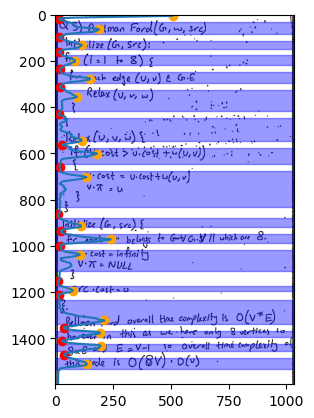

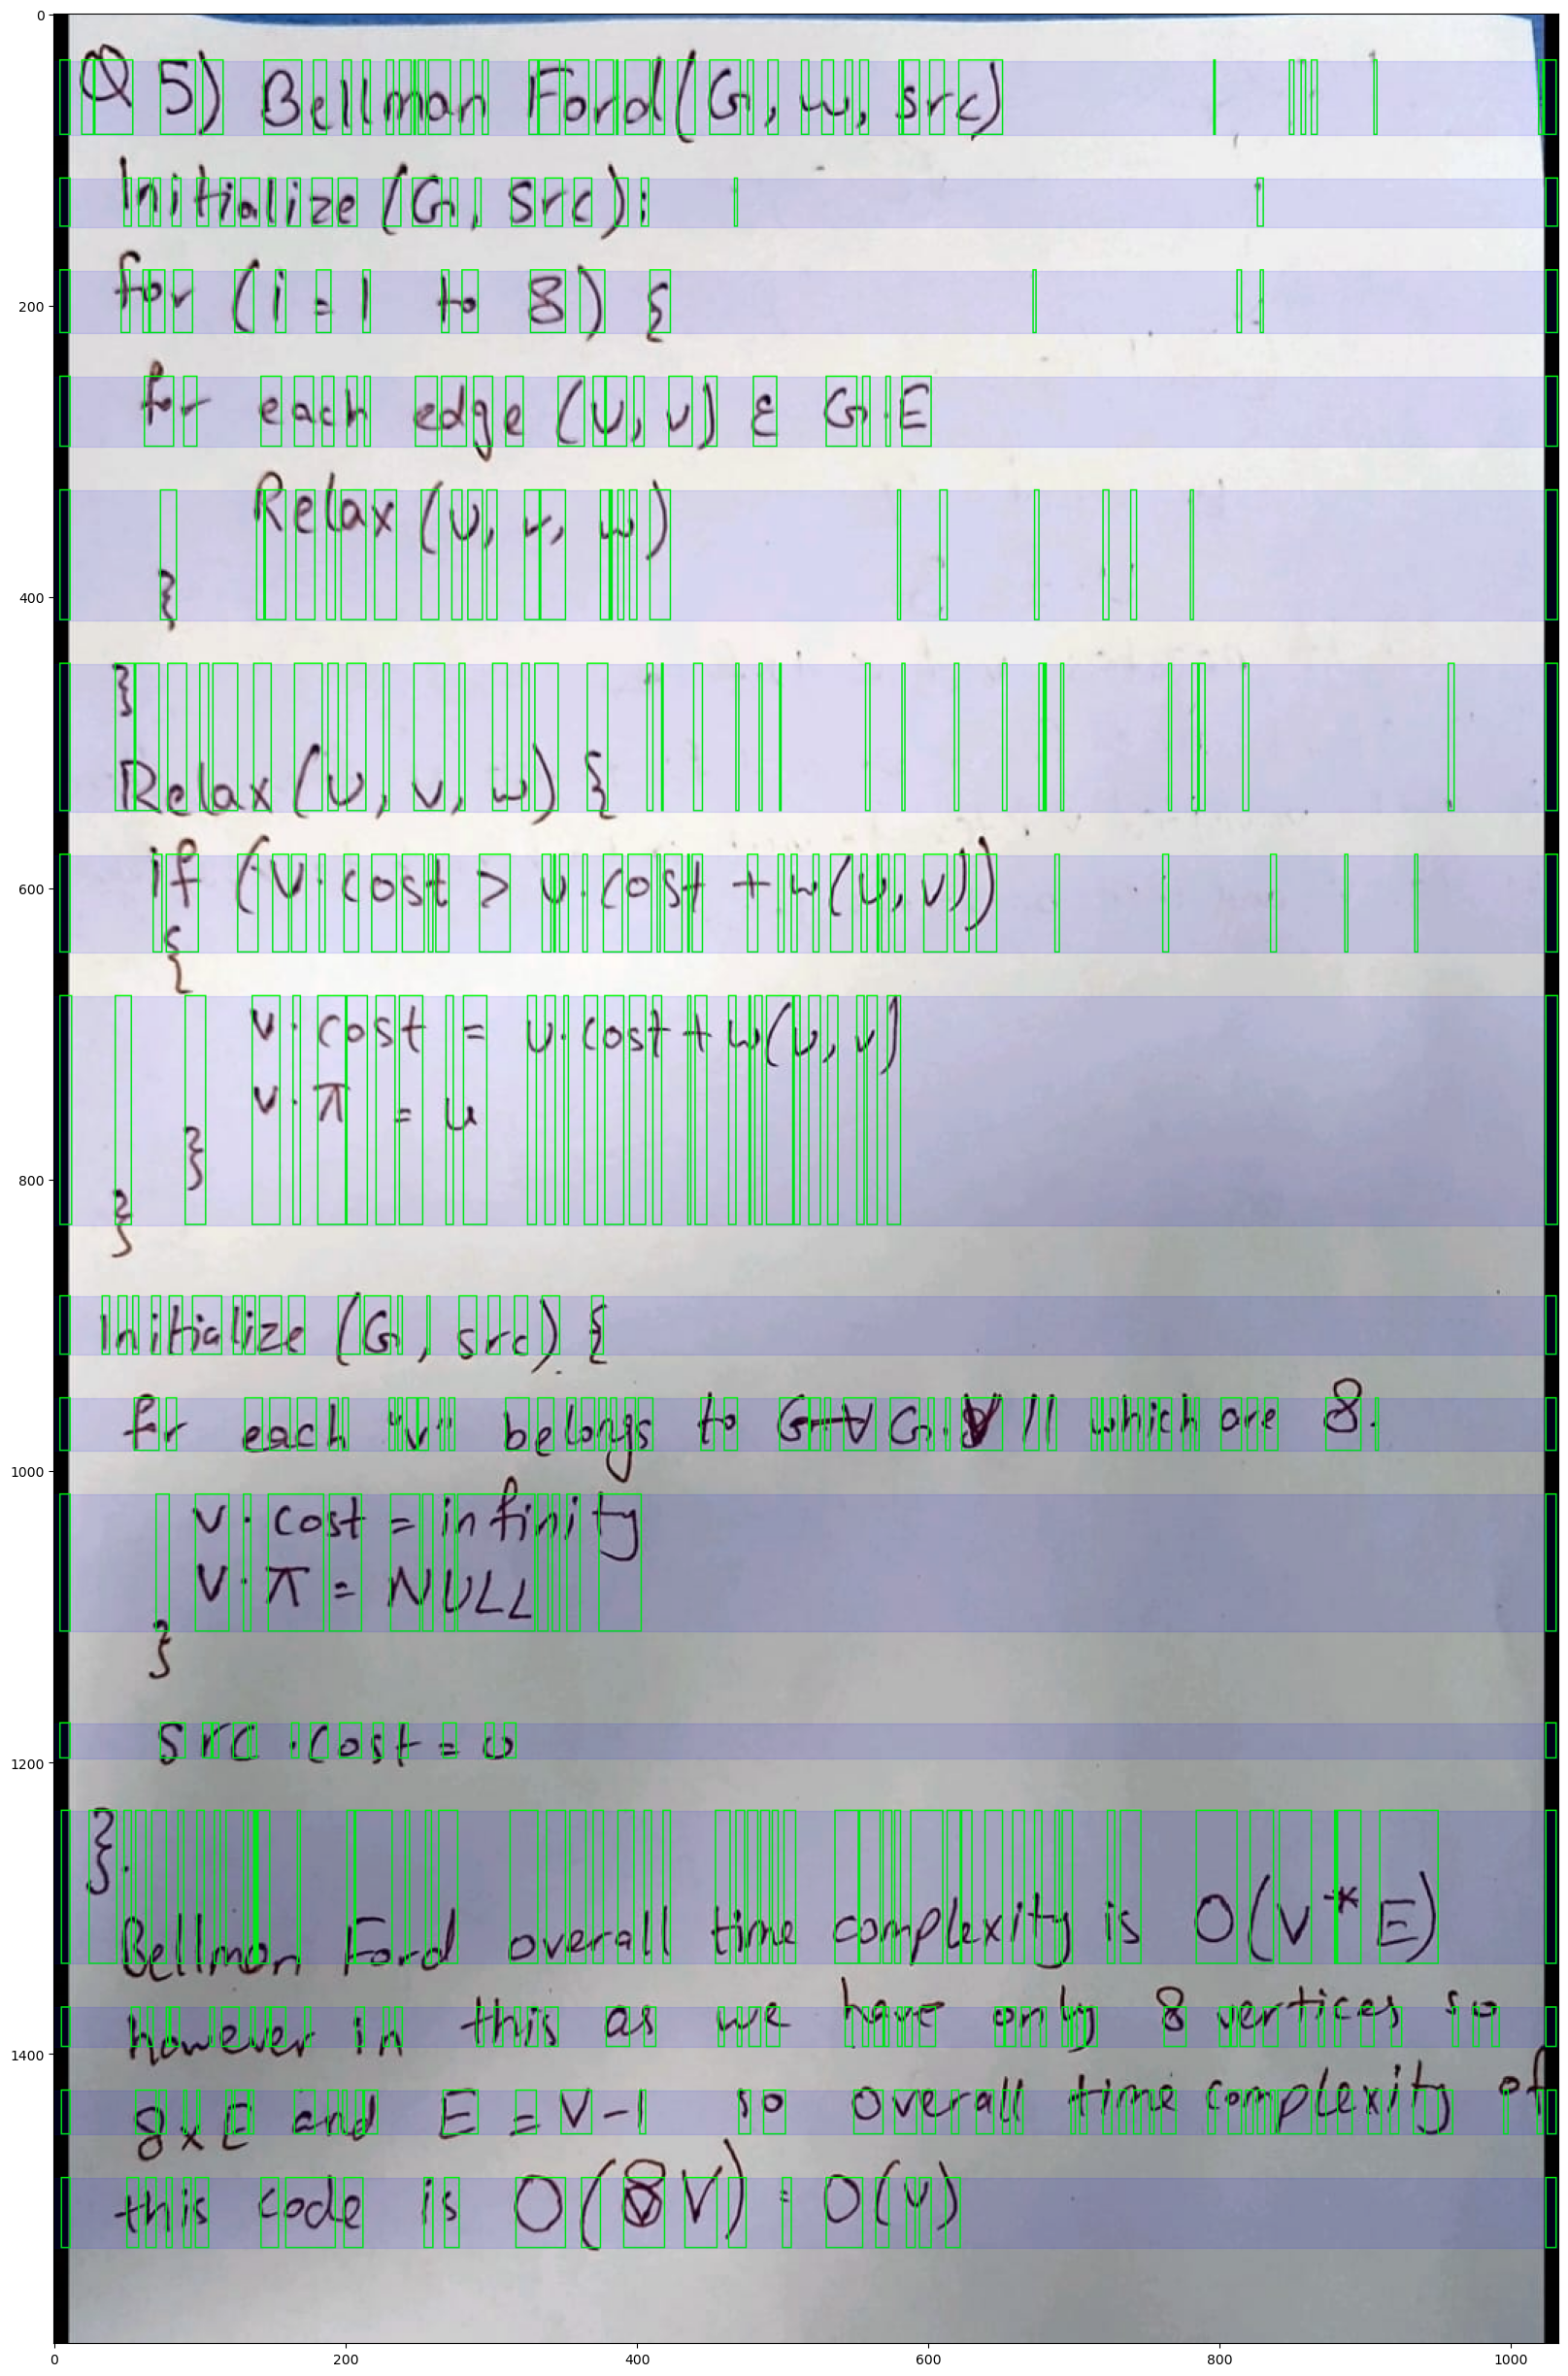

In [14]:
show_segments('samples/sample1.jpeg')